# install  python package
pip install elkai pandas numpy matplotlib tqdm torch

# 1 Base function
## 1.1 TSP solver - LKH

In [1]:
import elkai

cities_dict = {
    0: (0, 27),
    1: (4, 27),
    2: (65, 44),
}
cities = elkai.Coordinates2D(cities_dict)
print(cities.solve_tsp())

[0, 1, 2, 0]


# 1.2 instance generation # node = 10

In [2]:
import random
import pandas as pd


def instance_generate(n, grid_x, grid_y):
    index_list = list(range(grid_x * grid_y))
    nodes_index = random.sample(index_list, n)
    return nodes_index

In [3]:
nodes_index = instance_generate(10, 20, 20)
print(nodes_index)

[23, 57, 163, 31, 150, 114, 290, 299, 112, 237]


## 1.3 数据格式转换

In [4]:
# 数据格式转换（df--dict)
def nodes_index_to_dict(ni, grid_x, grid_y):
    nodes = {}
    for i in range(len(ni)):
        nodes[i] = (float(ni[i]%grid_x), float(int(ni[i]/grid_x)))
    return nodes

In [5]:
nodes_dict = nodes_index_to_dict(nodes_index, 20, 20)
print(nodes_dict)

{0: (3.0, 1.0), 1: (17.0, 2.0), 2: (3.0, 8.0), 3: (11.0, 1.0), 4: (10.0, 7.0), 5: (14.0, 5.0), 6: (10.0, 14.0), 7: (19.0, 14.0), 8: (12.0, 5.0), 9: (17.0, 11.0)}


In [6]:
cities = elkai.Coordinates2D(nodes_dict)
solution = cities.solve_tsp()

In [7]:
solution

[0, 2, 6, 7, 9, 4, 8, 5, 1, 3, 0]

## 1.4 目标值计算

In [8]:
import math as m
# 目标计算
def obj_cal(s, nodes_dict):
    obj = 0
    node_1 = s[0]
    for node_2 in s[1:]:
        obj += m.sqrt((nodes_dict[node_1][0] - nodes_dict[node_2][0]) ** 2 + (nodes_dict[node_1][1] - nodes_dict[node_2][1]) ** 2)
        node_1 = node_2
    return obj

In [9]:
obj = obj_cal(solution, nodes_dict)

In [10]:
obj

60.04118382321912

## 1.5 可视化

In [11]:
# 可视化
import matplotlib.pyplot as plt
def show_figure(solution, nodes_dict):
    xpoints, ypoints = [], []
    for node in solution:
        xpoints += [nodes_dict[node][0]]
        ypoints += [nodes_dict[node][1]]
        plt.text(xpoints[-1], ypoints[-1], node, fontsize=15)
    plt.scatter(xpoints, ypoints)
    plt.plot(xpoints, ypoints)

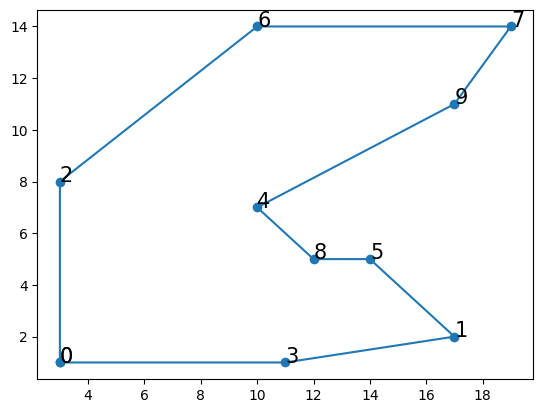

In [12]:
show_figure(solution, nodes_dict)

In [14]:
index_knn = get_knn_feature(nodes_dict, M=5)
print(index_knn)

{0: [2, 3, 4, 8, 5], 1: [5, 8, 3, 4, 9], 2: [0, 4, 6, 8, 3], 3: [8, 5, 1, 4, 0], 4: [8, 5, 3, 6, 2], 5: [8, 1, 4, 3, 9], 6: [4, 9, 7, 2, 8], 7: [9, 6, 5, 4, 8], 8: [5, 4, 3, 1, 9], 9: [7, 5, 6, 8, 4]}


# 2 数据准备

In [ ]:
import numpy as np
data_read =np.load(f'../data/data_{n_node}_{grid_x}_{grid_y}.npy')
num_sample = len(data_read)

# 3 网络搭建

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [34]:
X_train, X_test = graphs[:int(0.8 * num_sample), :, :, :], graphs[int(0.8 * num_sample):, :, :, :]
X_train_knn, X_test_knn = knn_dm_flat[:int(0.8 * num_sample), :], knn_dm_flat[int(0.8 * num_sample):, :]
y_train, y_test = labels[:int(0.8 * num_sample)], labels[int(0.8 * num_sample):]

## 3.1 CNN example

In [47]:
class RegressionCNN(nn.Module):
    def __init__(self, height, width):
        super(RegressionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 动态计算全连接层输入
        self.fc_input_dim = self.calculate_fc_input_dim(height, width)
        self.fc1 = nn.Linear(self.fc_input_dim, 64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)  # 输出一个连续值

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, self.fc_input_dim)  # 使用计算得到的维度
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x


In [35]:
X_train, X_test = kplusone_graphs[:int(0.8 * num_sample), :, :, :], kplusone_graphs[int(0.8 * num_sample):, :, :, :]
y_train, y_test = labels[:int(0.8 * num_sample)], labels[int(0.8 * num_sample):]

# TRAIN

In [121]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 数据
X_train = torch.tensor(X_train, dtype=torch.float64).to(device)
y_train = torch.tensor(y_train, dtype=torch.float64).to(device)

In [122]:
X_train.shape

torch.Size([8080, 6, 100, 100])

In [123]:
loss_list = []
# 创建数据加载器
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 初始化模型、损失函数和优化器
model = RegressionCNN(6, grid_x, grid_y, 1).to(device)

criterion = nn.MSELoss()  # 均方误差损失，常用于回归问题
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [124]:
def train_kplusone_graphs(model, train_loader, criterion, optimizer, epochs=10):
    loss_list = []
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, target in train_loader:
            data, target = data.to(device).float(), target.to(device).float()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        average_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Average Loss: {average_loss}')
        loss_list.append(average_loss)

    return loss_list


In [125]:
loss_list += train_kplusone_graphs(model, train_loader, criterion, optimizer)

Epoch 1, Average Loss: 25202.97101815291
Epoch 2, Average Loss: 467.6874971164493
Epoch 3, Average Loss: 376.9136655311885
Epoch 4, Average Loss: 331.5039642814576
Epoch 5, Average Loss: 221.19339469849595
Epoch 6, Average Loss: 219.0015471450926
Epoch 7, Average Loss: 246.12846386526513
Epoch 8, Average Loss: 196.60338310181626
Epoch 9, Average Loss: 225.3458805835153
Epoch 10, Average Loss: 165.1689521609329


In [135]:
loss_list += train_kplusone_graphs(model, train_loader, criterion, optimizer, 5)

Epoch 1, Average Loss: 157.77724847267933
Epoch 2, Average Loss: 185.50458905077355
Epoch 3, Average Loss: 173.5696474210484
Epoch 4, Average Loss: 145.55053867129828
Epoch 5, Average Loss: 140.93965869813454


In [143]:
loss_list += train_kplusone_graphs(model, train_loader, criterion, optimizer, 5)

Epoch 1, Average Loss: 137.88263840562715
Epoch 2, Average Loss: 146.90701873659148
Epoch 3, Average Loss: 134.99143468301128
Epoch 4, Average Loss: 126.80040386530358
Epoch 5, Average Loss: 134.67657287477508


# TEST

In [126]:
# 测试数据
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
# X_test_knn = torch.tensor(X_test_knn, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)
test_dataset = TensorDataset(X_test, y_test)
# test_dataset = TensorDataset(X_test, X_test_knn, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


In [144]:
# 测试模型
test(model, test_loader, criterion)
# test_multi_mode(model, test_loader, criterion)

Test Loss: 159.4968638420105


In [145]:
split_test = 2000
test_num_sample = len(y_test)
t_nn_1 = time.time()
with torch.no_grad():
    start = 0
    end = split_test
    test_output_y = []
    while True:
        test_output_y_i = model(X_test[start:end,:,:, :])
        test_output_y.append(test_output_y_i)
        if end >= test_num_sample:
            break
        end += split_test
        start += split_test
        end = min(end, test_num_sample)
test_output_y = torch.cat(test_output_y, dim=0).to(device)
t_nn_2 = time.time()
# 计算绝对差值向量
abs_diff = torch.abs(test_output_y - y_test)
# 将差值向量除以第一个向量
result = abs_diff / y_test
# 求平均值
average_result = torch.mean(result)

print("Test gap:", average_result.item())
print("max gap:", result.max().item())
print("min gap:", result.min().item())

Test gap: 0.015146883204579353
max gap: 0.1131528839468956
min gap: 1.1059408279834315e-05


# 7 save

In [150]:
from datetime import datetime
# 获取当前日期和时间
current_datetime = datetime.now()
# 格式化输出，仅保留月和日
formatted_date = current_datetime.strftime("%m%d")
# 保存模型状态字典
# torch.save(model, f'{model.__class__.__name__}_{formatted_date}_{n_node}_{grid_x}_{grid_y}.pth')
torch.save(model, f'{model.__class__.__name__}_{formatted_date}_{n_range[0]}_{n_range[1]}_{grid_x}_{grid_y}_rc-2.pth')

# # 直接加载整个模型
# model = torch.load('path_to_save.pth')

In [76]:
import netron
modelPath = "EnhancedCNN_Mplus_0527_16-25_100_100.pth"
netron.start(modelPath)

Serving 'EnhancedCNN_Mplus_0527_16-25_100_100.pth' at http://localhost:8080


('localhost', 8080)